In [1]:
from diffusers import AutoencoderKL, StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
import torch
from PIL import Image
import numpy as np
import time
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# VAE
Firstly we wanted to check maybe pretrained VAE is enough to generate similar but not the same desk pattern.

We are trying to take a little bit another latent distribution. 

But the results showed that it only gives noice to the original pattern, but not generates new pattern.

This is expected as VAE tries to reproduce original input.

In [2]:
sd_1_5_vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device).eval()
sdxl_vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae").to(device).eval()
eq_sdxl_vae = AutoencoderKL.from_pretrained("KBlueLeaf/EQ-SDXL-VAE").to(device).eval()

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [3]:
image_path = "/kaggle/input/floor-coverings-dataset/6_board_0.png"

image = Image.open(image_path).convert("RGB")
img_size = image.size
image_resized = image.resize((1024, 1024))

image_tensor = torch.tensor(np.array(image)).float() / 255.0
image_tensor = image_tensor.permute(2, 0, 1).unsqueeze(0).to(device, dtype=torch.float32)

In [4]:
def generate_image_using_noise(image_tensor, vae, noise_factor=0.7):
    start_time = time.time()
    
    with torch.no_grad():
        latents_dist = vae.encode(image_tensor * 2 - 1).latent_dist
        latents = latents_dist.sample()
    
    new_latents = latents + noise_factor * torch.randn_like(latents)
    
    with torch.no_grad():
        decoded_image = vae.decode(new_latents).sample
    
    decoded_image = (decoded_image / 2 + 0.5).clamp(0, 1)
    decoded_image = decoded_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    decoded_image = Image.fromarray((decoded_image * 255).astype(np.uint8))
    
    print("Noise method generation time:", time.time() - start_time)
    return decoded_image

def generate_image_sampling_different_latent_point(image_tensor, vae, variance_difference=0.001, variance_scaler=0.9):
    start_time = time.time()
    
    with torch.no_grad():
        latents_dist = vae.encode(image_tensor * 2 - 1).latent_dist
        latents = latents_dist.sample()

    latent_variance = torch.exp(variance_difference * latents_dist.logvar)
    new_latents = latents_dist.mean + variance_scaler * latent_variance * torch.randn_like(latent_variance)

    with torch.no_grad():
        decoded_image = vae.decode(new_latents).sample
    
    decoded_image = (decoded_image / 2 + 0.5).clamp(0, 1)
    decoded_image = decoded_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    decoded_image = Image.fromarray((decoded_image * 255).astype(np.uint8))
    
    print("Different latent point method generation time:", time.time() - start_time)
    return decoded_image
    
def generate_image_interpolating_noise(image_tensor, vae, alpha=0.5):
    # alpha controls blend strength
    start_time = time.time()
    
    with torch.no_grad():
        latents_dist = vae.encode(image_tensor * 2 - 1).latent_dist
        latents = latents_dist.sample()
        
    random_latents = torch.randn_like(latents)
    new_latents = alpha * latents + (1 - alpha) * random_latents  # Interpolation

    with torch.no_grad():
        decoded_image = vae.decode(new_latents).sample
    
    decoded_image = (decoded_image / 2 + 0.5).clamp(0, 1)
    decoded_image = decoded_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    decoded_image = Image.fromarray((decoded_image * 255).astype(np.uint8))
    
    print("Interpolating noise generation time:", time.time() - start_time)
    return decoded_image

In [5]:
sd_1_5_noise_image = generate_image_using_noise(image_tensor, sd_1_5_vae, 1.0)
sdxl_noise_image = generate_image_using_noise(image_tensor, sdxl_vae, 0.8)
eq_sdxl_noise_image = generate_image_using_noise(image_tensor, eq_sdxl_vae, 0.5)

sd_1_5_diff_latent_point_image = generate_image_sampling_different_latent_point(image_tensor, sd_1_5_vae, 0.001, 0.8)
sdxl_diff_latent_point_image = generate_image_sampling_different_latent_point(image_tensor, sdxl_vae, 0.01, 0.5)
eq_sdxl_diff_latent_point_image = generate_image_sampling_different_latent_point(image_tensor, eq_sdxl_vae, 0.0001, 0.8)

sd_1_5_interpolating_noise_image = generate_image_interpolating_noise(image_tensor, sd_1_5_vae, 0.6)
sdxl_interpolating_noise_image = generate_image_interpolating_noise(image_tensor, sdxl_vae, 0.6)
eq_sdxl_interpolating_noise_image = generate_image_interpolating_noise(image_tensor, eq_sdxl_vae, 0.5)

Noise method generation time: 0.8004860877990723
Noise method generation time: 0.14549756050109863
Noise method generation time: 0.14853906631469727
Different latent point method generation time: 0.14574480056762695
Different latent point method generation time: 0.14369750022888184
Different latent point method generation time: 0.14412379264831543
Interpolating noise generation time: 0.1447279453277588
Interpolating noise generation time: 0.144608736038208
Interpolating noise generation time: 0.14330458641052246


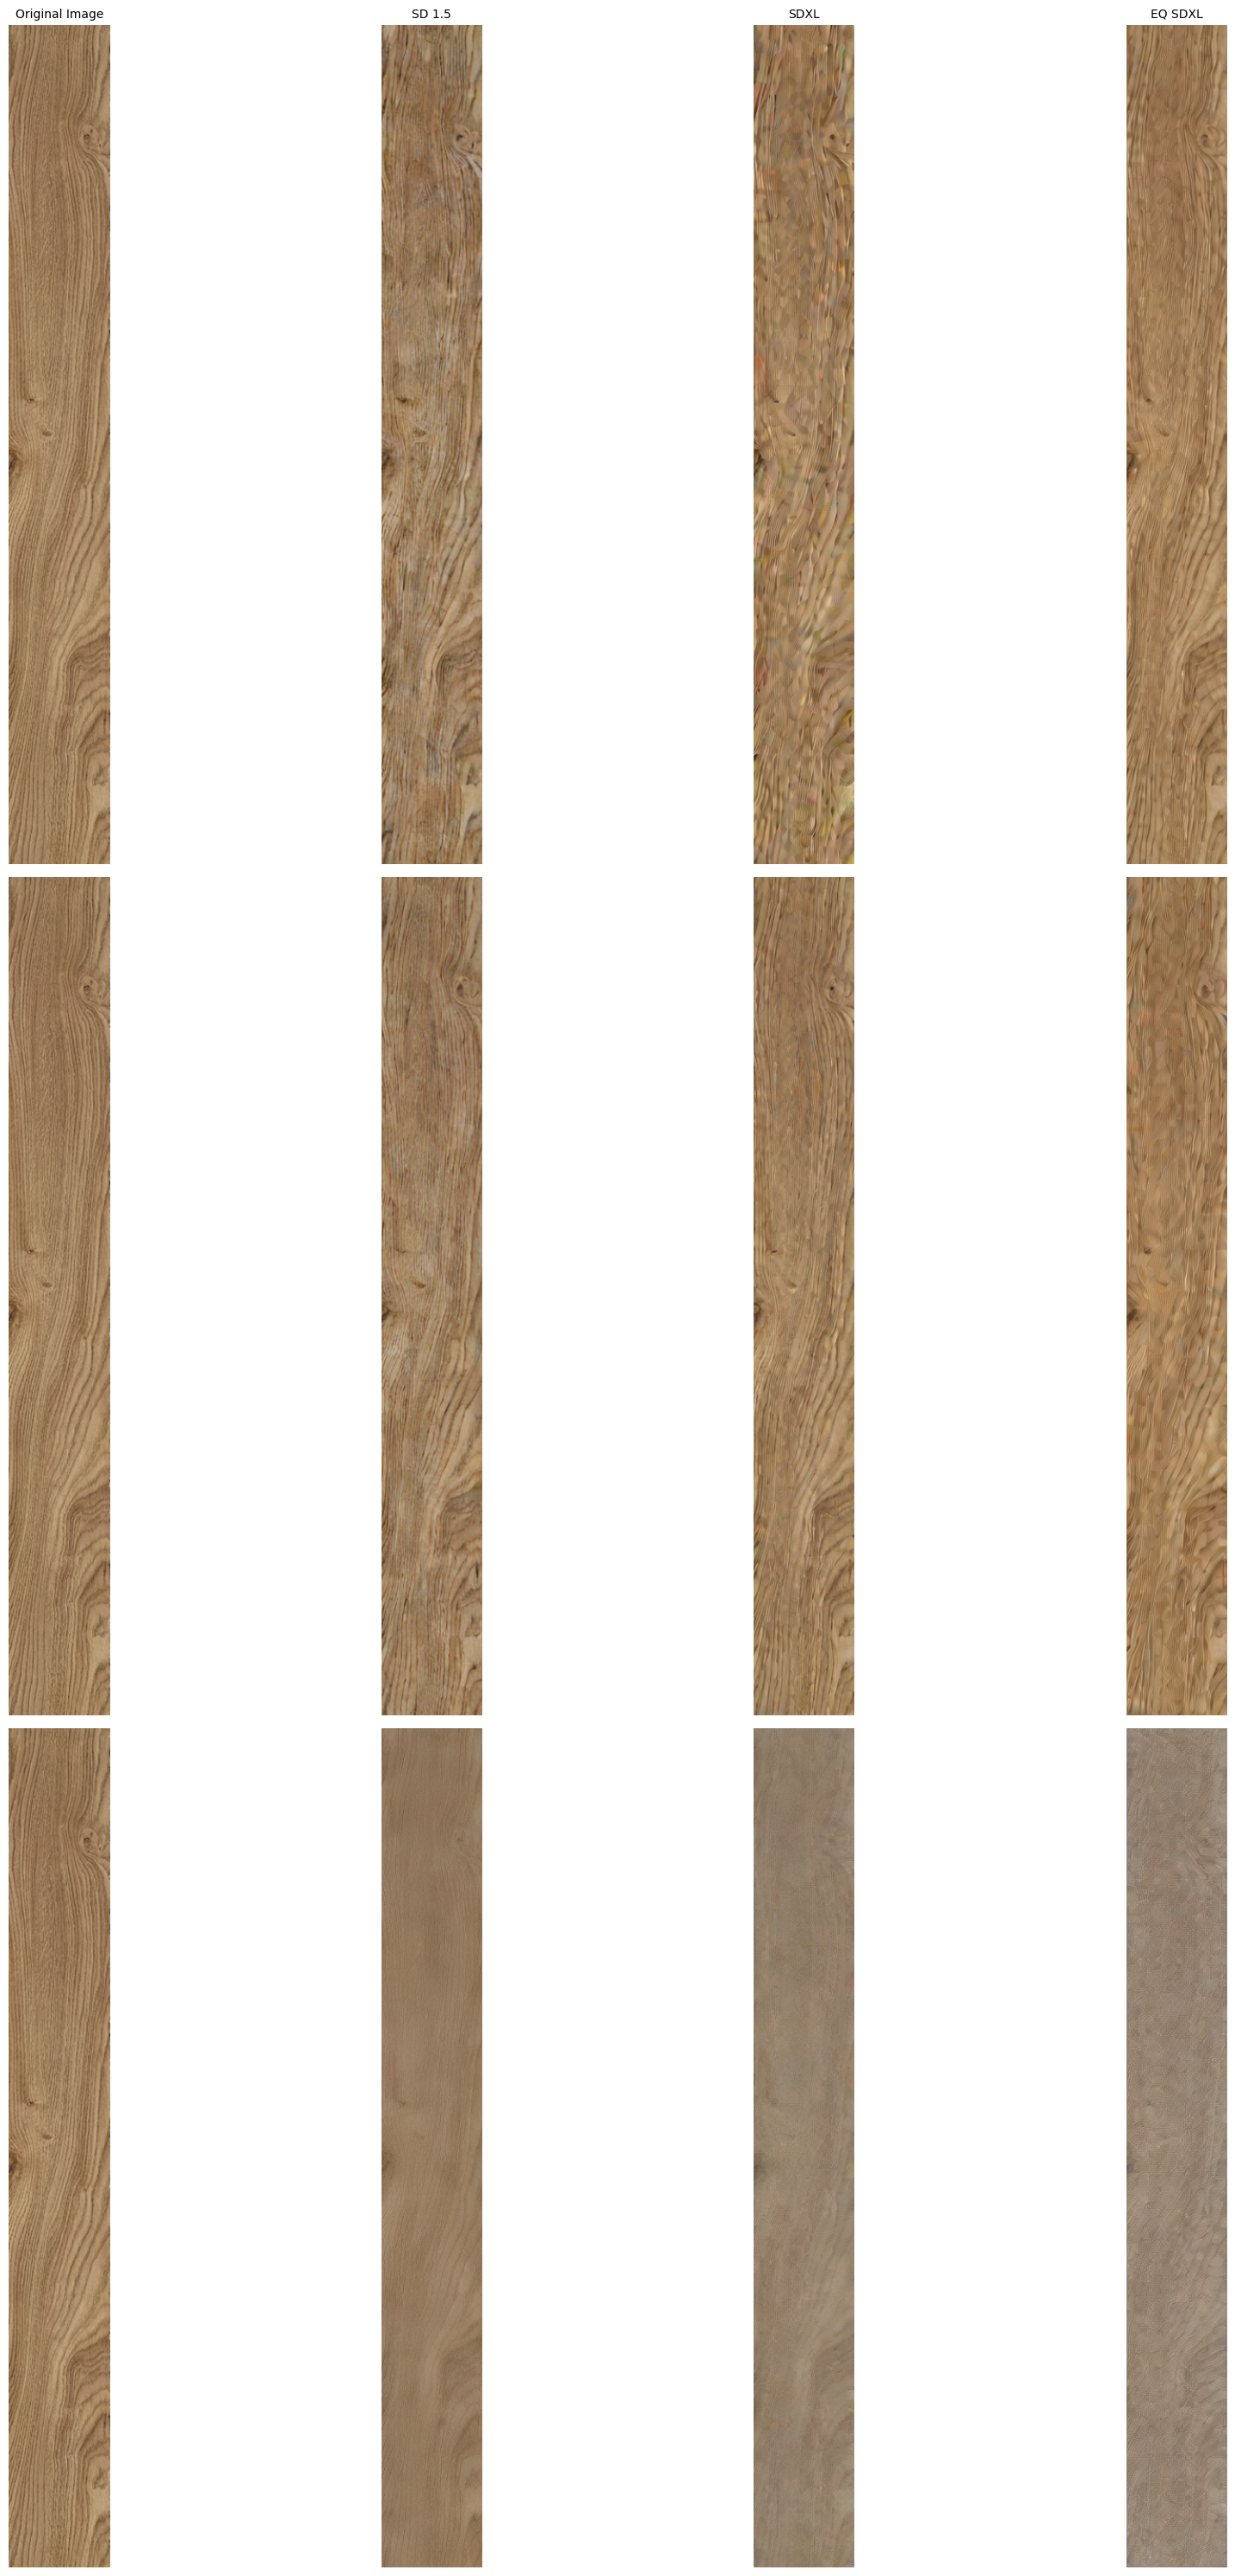

In [6]:
fig, ax = plt.subplots(3, 4, figsize=(20, 30))

ax[0][0].imshow(image)
ax[0][0].axis('off')
ax[0][0].set_title("Original Image", fontsize=10)

ax[0][1].imshow(sd_1_5_noise_image)
ax[0][1].axis('off')
ax[0][1].set_title("SD 1.5", fontsize=10)

ax[0][2].imshow(sdxl_noise_image)
ax[0][2].axis('off')
ax[0][2].set_title("SDXL", fontsize=10)

ax[0][3].imshow(eq_sdxl_noise_image)
ax[0][3].axis('off')
ax[0][3].set_title("EQ SDXL", fontsize=10)

ax[1][0].imshow(image)
ax[1][0].axis('off')

ax[1][1].imshow(sd_1_5_diff_latent_point_image)
ax[1][1].axis('off')

ax[1][2].imshow(sdxl_diff_latent_point_image)
ax[1][2].axis('off')

ax[1][3].imshow(eq_sdxl_diff_latent_point_image)
ax[1][3].axis('off')

ax[2][0].imshow(image)
ax[2][0].axis('off')

ax[2][1].imshow(sd_1_5_interpolating_noise_image)
ax[2][1].axis('off')

ax[2][2].imshow(sdxl_interpolating_noise_image)
ax[2][2].axis('off')

ax[2][3].imshow(eq_sdxl_interpolating_noise_image)
ax[2][3].axis('off')

plt.tight_layout()
plt.show()

# As we can see pretreined VAE is only offeset a little bit in the latent space giving a noise. But it cannot slightly change to another distribution to get new pattern. (Most probably it's decoder trying to reproduce initial pattern, taking another latent distribution, so we need to train it to generate new patterns.)

# Stable Diffusion

In [19]:
from diffusers import AutoPipelineForImage2Image

pipeline = AutoPipelineForImage2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipeline.enable_model_cpu_offload()


model_index.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/4.52G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [52]:
prompt = "Another wooden desk"

new_image = pipeline(prompt=prompt, image=image, strength=0.25, guidance_scale=10.0).images[0]
new_image_resized = new_image.resize(img_size)

  0%|          | 0/12 [00:00<?, ?it/s]

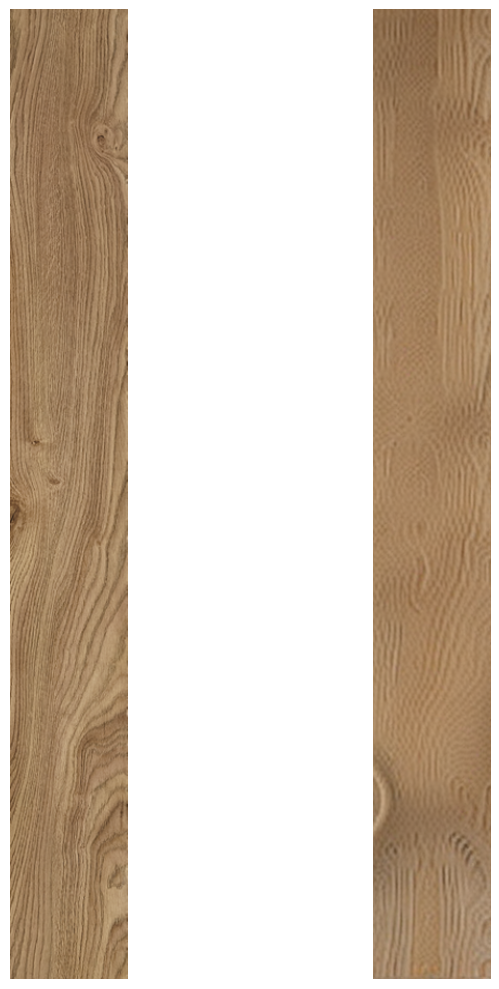

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image)
ax[0].axis('off')
ax[1].imshow(new_image_resized)
ax[1].axis('off')
plt.tight_layout()
plt.show()

In [54]:
prompt = "Another wooden desk"

new_image = pipeline(prompt=prompt, image=image_resized, strength=0.25, guidance_scale=10.0).images[0]
new_image_resized = new_image.resize(img_size)

  0%|          | 0/12 [00:00<?, ?it/s]

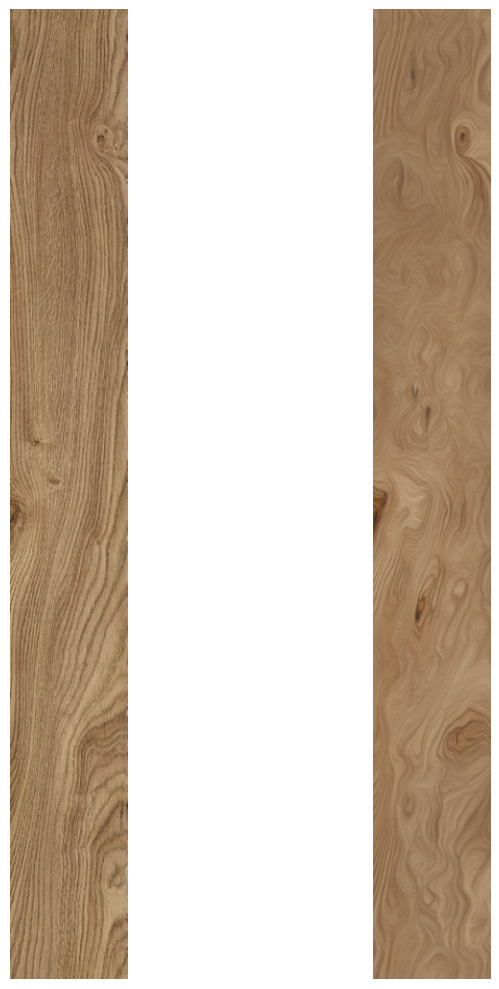

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image)
ax[0].axis('off')
ax[1].imshow(new_image_resized)
ax[1].axis('off')
plt.tight_layout()
plt.show()

# The result showed, that SDXL can generate new pattern, but it need to be trained on our data to generate more exact image (too many imaginary results). Also it has significant disadvantage as speed of generation (25 sec on high resolution and 6 sec on low resolution on GPU P100 on kaggle) and dependency on memory on gpu

# While VAE is fast (0.15 sec on GPU P100 on kaggle) and more lightweight than SD

# So we will try to train VAE, to not reproduce original images, but to reproduce similar images.

# If even after training VAE will show bad results, we will need to train sdxl